# Exportación de Datos Históricos - Demanda Eléctrica

Este notebook carga datos históricos de demanda eléctrica desde **2023-01-01** hasta **2025-09-20** en frecuencia horaria y los guarda en formato CSV.

**Propósito**: Crear un archivo histórico completo antes del período de predicciones para tener continuidad en los datos.

**Flujo**:
1. Carga de datos desde `data_parquet_clean` (REE, meteo, precios)
2. Estandarización a frecuencia horaria (igual que NB01 y NB10)
3. Integración de datos
4. Exportación a CSV con columnas:
   - `datetime`: Fecha y hora
   - `demanda_real`: Demanda real de REE
   - `demanda_prevista_ree`: Previsión oficial de REE
   - `demanda_prevista_modelo`: Vacío (sin predicciones)

**Output**: `app/datos/demanda.csv` (añadiendo al archivo existente)

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Exportación de Datos Históricos")
print("="*60)

Exportación de Datos Históricos


## 1. Configuración de Parámetros

In [2]:
# PARÁMETROS DE RANGO HISTÓRICO
FECHA_INICIO = pd.Timestamp('2023-01-01 00:00:00')
FECHA_FIN = pd.Timestamp('2025-09-20 23:00:00')

print(f"Rango histórico configurado:")
print(f"  Inicio: {FECHA_INICIO}")
print(f"  Fin:    {FECHA_FIN}")
print(f"  Duración: {(FECHA_FIN - FECHA_INICIO).days + 1} días")
print(f"  Horas totales esperadas: {((FECHA_FIN - FECHA_INICIO).days + 1) * 24}")

Rango histórico configurado:
  Inicio: 2023-01-01 00:00:00
  Fin:    2025-09-20 23:00:00
  Duración: 994 días
  Horas totales esperadas: 23856


## 2. Rutas de Archivos

In [3]:
# Rutas base
BASE_DIR = Path('../..')
DATA_DIR = BASE_DIR / 'data'
APP_DIR = BASE_DIR / 'app'

# Rutas de entrada (parquet_clean)
REE_CLEAN_DIR = DATA_DIR / 'ree' / 'data_parquet_clean' / 'demanda'
METEO_CLEAN_DIR = DATA_DIR / 'climatologia' / 'data_parquet_clean' / 'meteo'
PRECIO_CLEAN_DIR = DATA_DIR / 'precio_luz' / 'data_parquet_clean' / 'precios_luz'

# Rutas de salida
APP_DATOS_DIR = APP_DIR / 'data'
APP_DATOS_DIR.mkdir(parents=True, exist_ok=True)

print("Rutas configuradas:")
print(f"  REE: {REE_CLEAN_DIR}")
print(f"  Meteo: {METEO_CLEAN_DIR}")
print(f"  Precios: {PRECIO_CLEAN_DIR}")
print(f"  Salida: {APP_DATOS_DIR}")

Rutas configuradas:
  REE: ../../data/ree/data_parquet_clean/demanda
  Meteo: ../../data/climatologia/data_parquet_clean/meteo
  Precios: ../../data/precio_luz/data_parquet_clean/precios_luz
  Salida: ../../app/data


## 3. Función de Estandarización Horaria

Función idéntica a NB01 y NB10 para estandarizar datos a frecuencia horaria.

In [4]:
def estandarizar_frecuencia_horaria(df, columnas_numericas, metodo='mean'):
    """
    Estandariza un dataframe a frecuencia horaria sin huecos ni duplicados.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con columna 'datetime'
    columnas_numericas : list
        Lista de columnas numéricas a procesar
    metodo : str
        'mean' (agregación por media), 'ffill' (forward fill), 'interpolate' (interpolación lineal)
    
    Returns:
    --------
    pd.DataFrame estandarizado a frecuencia horaria
    """
    # 1. Ordenar por datetime
    df = df.sort_values('datetime').copy()
    
    # 2. Asegurar que datetime esté en formato datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # 3. Redondear a la hora más cercana (por si hay segundos/minutos)
    df['datetime'] = df['datetime'].dt.floor('H')
    
    # 4. Eliminar duplicados según el método
    if metodo == 'mean':
        # Agrupar por hora y promediar
        df_grouped = df.groupby('datetime')[columnas_numericas].mean().reset_index()
    elif metodo == 'ffill':
        # Tomar el primer valor de cada hora
        df_temp = df[['datetime'] + columnas_numericas].copy()
        df_grouped = df_temp.drop_duplicates(subset='datetime', keep='first').reset_index(drop=True)
    elif metodo == 'interpolate':
        # Eliminar duplicados tomando la media
        df_grouped = df.groupby('datetime')[columnas_numericas].mean().reset_index()
    else:
        raise ValueError(f"Método '{metodo}' no reconocido")
    
    # 5. Crear rango completo de horas (sin huecos)
    fecha_min = df_grouped['datetime'].min()
    fecha_max = df_grouped['datetime'].max()
    rango_completo = pd.date_range(start=fecha_min, end=fecha_max, freq='H')
    
    # 6. Reindexar para llenar huecos
    df_estandarizado = df_grouped.set_index('datetime').reindex(rango_completo)
    
    # 7. Rellenar huecos según el método
    if metodo == 'mean' or metodo == 'interpolate':
        # Interpolación lineal para valores continuos
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].interpolate(method='linear', limit_direction='both')
    elif metodo == 'ffill':
        # Forward fill para valores discretos
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].ffill()
        # Si quedan NaN al inicio, usar backfill
        df_estandarizado[columnas_numericas] = df_estandarizado[columnas_numericas].bfill()
    
    # 8. Resetear índice
    df_estandarizado.index.name = 'datetime'
    df_estandarizado = df_estandarizado.reset_index()
    
    return df_estandarizado

print("✓ Función de estandarización definida")

✓ Función de estandarización definida


## 4. Cargar Datos desde Parquet Clean

In [5]:
print("="*80)
print("CARGANDO DATOS DESDE PARQUET_CLEAN")
print("="*80)

print("\n1. Cargando datos de REE (Demanda)...")
df_ree = pd.read_parquet(REE_CLEAN_DIR)

# Normalizar nombre de columna temporal
if 'Hora' in df_ree.columns:
    df_ree = df_ree.rename(columns={'Hora': 'datetime'})
elif 'hora' in df_ree.columns:
    df_ree = df_ree.rename(columns={'hora': 'datetime'})
elif 'time' in df_ree.columns:
    df_ree = df_ree.rename(columns={'time': 'datetime'})

df_ree['datetime'] = pd.to_datetime(df_ree['datetime'])

# Filtrar por rango histórico
df_ree = df_ree[(df_ree['datetime'] >= FECHA_INICIO) & (df_ree['datetime'] <= FECHA_FIN)].copy()

print(f"  Registros cargados: {len(df_ree):,}")
print(f"  Período: {df_ree['datetime'].min()} a {df_ree['datetime'].max()}")
print(f"  Columnas: {list(df_ree.columns)}")

CARGANDO DATOS DESDE PARQUET_CLEAN

1. Cargando datos de REE (Demanda)...
  Registros cargados: 286,261
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00
  Columnas: ['datetime', 'Real', 'Prevista', 'Programada', 'year']


In [6]:
print("\n2. Cargando datos meteorológicos...")
try:
    df_meteo = pd.read_parquet(METEO_CLEAN_DIR)
    
    # Normalizar nombre de columna temporal
    if 'time' in df_meteo.columns:
        df_meteo = df_meteo.rename(columns={'time': 'datetime'})
    elif 'Time' in df_meteo.columns:
        df_meteo = df_meteo.rename(columns={'Time': 'datetime'})
    elif 'hora' in df_meteo.columns:
        df_meteo = df_meteo.rename(columns={'hora': 'datetime'})
    
    df_meteo['datetime'] = pd.to_datetime(df_meteo['datetime'])
    df_meteo = df_meteo[(df_meteo['datetime'] >= FECHA_INICIO) & (df_meteo['datetime'] <= FECHA_FIN)]
    
    print(f"  Registros cargados: {len(df_meteo):,}")
except Exception as e:
    print(f"  ADVERTENCIA: No se pudieron cargar datos meteorológicos: {e}")
    df_meteo = pd.DataFrame()


2. Cargando datos meteorológicos...
  Registros cargados: 1,097,376


In [7]:
print("\n3. Cargando datos de precios...")
try:
    df_precio = pd.read_parquet(PRECIO_CLEAN_DIR)
    
    # Normalizar nombre de columna temporal
    if 'time' in df_precio.columns:
        df_precio = df_precio.rename(columns={'time': 'datetime'})
    elif 'Hora' in df_precio.columns:
        df_precio = df_precio.rename(columns={'Hora': 'datetime'})
    elif 'hora' in df_precio.columns:
        df_precio = df_precio.rename(columns={'hora': 'datetime'})
    
    df_precio['datetime'] = pd.to_datetime(df_precio['datetime'])
    df_precio = df_precio[(df_precio['datetime'] >= FECHA_INICIO) & (df_precio['datetime'] <= FECHA_FIN)].copy()
    
    print(f"  Registros cargados: {len(df_precio):,}")
except Exception as e:
    print(f"  ADVERTENCIA: No se pudieron cargar datos de precio: {e}")
    df_precio = pd.DataFrame()


3. Cargando datos de precios...
  Registros cargados: 23,856


## 5. Estandarización a Frecuencia Horaria

Aplicar la misma estandarización que en NB01 para garantizar frecuencia horaria consistente.

In [8]:
print("\n" + "="*80)
print("ESTANDARIZANDO A FRECUENCIA HORARIA")
print("="*80)

# 1. REE (Demanda): Agregación de 5min a 1h usando media
print("\n1. Procesando REE (Demanda)...")
print(f"   Registros antes: {len(df_ree):,}")

# Identificar columnas numéricas
ree_cols = [col for col in df_ree.columns 
            if col != 'datetime' 
            and df_ree[col].dtype in ['float64', 'int64', 'float32', 'int32']]

print(f"   Columnas a procesar: {ree_cols}")

df_ree_horario = estandarizar_frecuencia_horaria(
    df_ree,
    columnas_numericas=ree_cols,
    metodo='mean'
)

print(f"   Registros después: {len(df_ree_horario):,}")
print(f"   Frecuencia: {df_ree_horario['datetime'].diff().mode()[0]}")


ESTANDARIZANDO A FRECUENCIA HORARIA

1. Procesando REE (Demanda)...
   Registros antes: 286,261
   Columnas a procesar: ['Real', 'Prevista', 'Programada']
   Registros después: 23,856
   Frecuencia: 0 days 01:00:00


In [9]:
# 2. METEO: Estandarizar si existe
if not df_meteo.empty:
    print("\n2. Procesando METEO...")
    print(f"   Registros antes: {len(df_meteo):,}")
    
    meteo_cols = [col for col in df_meteo.columns 
                  if col != 'datetime' 
                  and df_meteo[col].dtype in ['float64', 'int64', 'float32', 'int32']]
    
    print(f"   Columnas a procesar: {len(meteo_cols)} variables meteorológicas")
    
    df_meteo_horario = estandarizar_frecuencia_horaria(
        df_meteo,
        columnas_numericas=meteo_cols,
        metodo='interpolate'
    )
    
    print(f"   Registros después: {len(df_meteo_horario):,}")
else:
    print("\n2. Sin datos meteorológicos")
    df_meteo_horario = pd.DataFrame()


2. Procesando METEO...
   Registros antes: 1,097,376
   Columnas a procesar: 17 variables meteorológicas
   Registros después: 23,856


In [10]:
# 3. PRECIOS: Estandarizar si existe
if not df_precio.empty:
    print("\n3. Procesando PRECIOS...")
    print(f"   Registros antes: {len(df_precio):,}")
    
    precio_cols = [col for col in df_precio.columns 
                   if col != 'datetime' 
                   and df_precio[col].dtype in ['float64', 'int64', 'float32', 'int32']]
    
    print(f"   Columnas a procesar: {precio_cols}")
    
    df_precio_horario = estandarizar_frecuencia_horaria(
        df_precio,
        columnas_numericas=precio_cols,
        metodo='mean'
    )
    
    print(f"   Registros después: {len(df_precio_horario):,}")
else:
    print("\n3. Sin datos de precios")
    df_precio_horario = pd.DataFrame()

print("\n" + "="*80)


3. Procesando PRECIOS...
   Registros antes: 23,856
   Columnas a procesar: ['GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC', 'PMHVHC', 'SAHGEN', 'SAHNOC', 'SAHVHC', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'INTGEN', 'INTNOC', 'INTVHC', 'PCAPGEN', 'PCAPNOC', 'PCAPVHC', 'TEUGEN', 'TEUNOC', 'TEUVHC', 'CCVGEN', 'CCVNOC', 'CCVVHC', 'price', 'PCB', 'CYM', 'COF2TD', 'PMHPCB', 'PMHCYM', 'SAHPCB', 'SAHCYM', 'FOMPCB', 'FOMCYM', 'FOSPCB', 'FOSCYM', 'INTPCB', 'INTCYM', 'PCAPPCB', 'PCAPCYM', 'TEUPCB', 'TEUCYM', 'CCVPCB', 'CCVCYM', 'EDSRPCB', 'EDSRCYM', 'EDCGASPCB', 'EDCGASCYM', 'TAHPCB', 'TAHCYM']
   Registros después: 23,856



## 6. Integración de Datos

Combinar todas las fuentes en un único DataFrame.

In [11]:
print("\n" + "="*80)
print("INTEGRACIÓN DE DATOS")
print("="*80)

# Base: REE horario
df = df_ree_horario.copy()
print(f"\nBase (REE): {df.shape}")

# Merge con meteo si existe
if not df_meteo_horario.empty:
    # Si hay columna 'city' o 'ciudad', agregar por datetime
    if 'city' in df_meteo_horario.columns or 'ciudad' in df_meteo_horario.columns:
        print("  Agregando datos meteorológicos por promedio...")
        columnas_meteo = [col for col in df_meteo_horario.columns 
                         if col not in ['datetime', 'city', 'ciudad']]
        df_meteo_agg = df_meteo_horario.groupby('datetime')[columnas_meteo].mean().reset_index()
    else:
        df_meteo_agg = df_meteo_horario
    
    df = df.merge(df_meteo_agg, on='datetime', how='left')
    print(f"  Después de meteo: {df.shape}")

# Merge con precio si existe
if not df_precio_horario.empty:
    df = df.merge(df_precio_horario, on='datetime', how='left', suffixes=('', '_precio'))
    print(f"  Después de precio: {df.shape}")

print(f"\nDataFrame integrado: {df.shape}")
print(f"Período: {df['datetime'].min()} a {df['datetime'].max()}")
print("="*80)


INTEGRACIÓN DE DATOS

Base (REE): (23856, 4)
  Después de meteo: (23856, 21)
  Después de precio: (23856, 77)

DataFrame integrado: (23856, 77)
Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00


## 7. Crear DataFrame de Salida

Estructura final para exportar:
- `dia`: Fecha (date)
- `hora`: Hora del día (0-23)
- `datetime`: Timestamp completo
- `demanda_real`: Demanda real de REE
- `demanda_prevista_ree`: Previsión oficial de REE
- `demanda_prevista_modelo`: Vacío (para futuras predicciones)

In [12]:
print("\n" + "="*80)
print("CREAR DATAFRAME DE SALIDA")
print("="*80)

# Buscar columna de demanda real
demanda_real = None
if 'real' in df.columns:
    demanda_real = df['real'].values
    print("✓ Demanda real encontrada: 'real'")
elif 'demanda' in df.columns:
    demanda_real = df['demanda'].values
    print("✓ Demanda real encontrada: 'demanda'")
elif 'Real' in df.columns:
    demanda_real = df['Real'].values
    print("✓ Demanda real encontrada: 'Real'")
else:
    print("  ADVERTENCIA: No se encontró columna de demanda real")
    demanda_real = np.nan

# Buscar columna de previsión REE
demanda_ree_prevista = None
if 'prevista' in df.columns:
    demanda_ree_prevista = df['prevista'].values
    print("✓ Previsión REE encontrada: 'prevista'")
elif 'Prevista' in df.columns:
    demanda_ree_prevista = df['Prevista'].values
    print("✓ Previsión REE encontrada: 'Prevista'")
elif 'demanda_prevista' in df.columns:
    demanda_ree_prevista = df['demanda_prevista'].values
    print("✓ Previsión REE encontrada: 'demanda_prevista'")
else:
    prev_cols = [col for col in df.columns if 'prev' in col.lower()]
    if prev_cols:
        demanda_ree_prevista = df[prev_cols[0]].values
        print(f"✓ Previsión REE encontrada: '{prev_cols[0]}'")
    else:
        print("  Sin previsión de REE disponible")
        demanda_ree_prevista = np.nan

# Crear DataFrame de salida
df_output = pd.DataFrame({
    'datetime': df['datetime'].values,
    'demanda_real': demanda_real if demanda_real is not None else np.nan,
    'demanda_prevista_ree': demanda_ree_prevista if demanda_ree_prevista is not None else np.nan,
    'demanda_prevista_modelo': np.nan  # Vacío - sin predicciones
})

# Extraer día y hora
df_output['dia'] = df_output['datetime'].dt.date
df_output['hora'] = df_output['datetime'].dt.hour

# Reordenar columnas
df_output = df_output[['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']]

print(f"\nDataFrame de salida:")
print(f"  Registros: {len(df_output):,}")
print(f"  Período: {df_output['datetime'].min()} a {df_output['datetime'].max()}")
print(f"  Columnas: {list(df_output.columns)}")

print(f"\nPrimeras 10 filas:")
print(df_output.head(10))

print(f"\nÚltimas 10 filas:")
print(df_output.tail(10))

print("="*80)


CREAR DATAFRAME DE SALIDA
✓ Demanda real encontrada: 'Real'
✓ Previsión REE encontrada: 'Prevista'

DataFrame de salida:
  Registros: 23,856
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00
  Columnas: ['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']

Primeras 10 filas:
          dia  hora            datetime  demanda_real  demanda_prevista_ree  \
0  2023-01-01     0 2023-01-01 00:00:00     21419.667             21504.750   
1  2023-01-01     1 2023-01-01 01:00:00     20627.083             20799.500   
2  2023-01-01     2 2023-01-01 02:00:00     19437.083             19580.250   
3  2023-01-01     3 2023-01-01 03:00:00     18331.750             18412.500   
4  2023-01-01     4 2023-01-01 04:00:00     17712.167             17726.750   
5  2023-01-01     5 2023-01-01 05:00:00     17325.917             17291.250   
6  2023-01-01     6 2023-01-01 06:00:00     17361.500             17302.000   
7  2023-01-01     7 2023-01-01 07:00:00     17

## 8. Validación de Datos

In [13]:
print("\n" + "="*80)
print("VALIDACIÓN DE DATOS")
print("="*80)

# Verificar continuidad temporal
diffs = df_output['datetime'].diff()
huecos = diffs[diffs != pd.Timedelta(hours=1)]

if len(huecos) > 1:  # El primero siempre es NaT
    print(f"\nADVERTENCIA: Se encontraron {len(huecos)-1} huecos en la serie temporal")
    for idx in huecos.index[1:6]:  # Mostrar primeros 5 huecos
        print(f"  Entre {df_output.loc[idx-1, 'datetime']} y {df_output.loc[idx, 'datetime']}")
else:
    print("\nSerie temporal continua (sin huecos)")

# Verificar valores nulos
nulos = df_output.isnull().sum()
if nulos.sum() > 0:
    print("\nValores nulos por columna:")
    for col in nulos.index:
        if nulos[col] > 0:
            pct = (nulos[col] / len(df_output)) * 100
            print(f"  {col}: {nulos[col]:,} ({pct:.2f}%)")

# Estadísticas de demanda real
if not df_output['demanda_real'].isna().all():
    print(f"\nDemanda real - Media: {df_output['demanda_real'].mean():.2f} MW | Min: {df_output['demanda_real'].min():.2f} | Max: {df_output['demanda_real'].max():.2f}")

print("="*80)


VALIDACIÓN DE DATOS

Serie temporal continua (sin huecos)

Valores nulos por columna:
  demanda_prevista_modelo: 23,856 (100.00%)

Demanda real - Media: 28359.08 MW | Min: 12562.67 | Max: 42126.00


## 9. Guardar Datos Históricos

In [14]:
print("\n" + "="*80)
print("GUARDAR DATOS HISTÓRICOS")
print("="*80)

# Ruta del archivo CSV principal
output_csv = APP_DATOS_DIR / 'demanda.csv'

# Verificar si existe archivo previo
if output_csv.exists():
    print(f"\nArchivo existente encontrado: {output_csv}")
    df_existente = pd.read_csv(output_csv)
    df_existente['datetime'] = pd.to_datetime(df_existente['datetime'])
    
    print(f"Registros existentes: {len(df_existente):,}")
    print(f"Período existente: {df_existente['datetime'].min()} a {df_existente['datetime'].max()}")
    
    # Concatenar nuevos datos con existentes
    print(f"\nConcatenando datos históricos con existentes...")
    df_combined = pd.concat([df_output, df_existente], ignore_index=True)
    
    # Eliminar duplicados (mantener el más reciente por datetime)
    registros_antes = len(df_combined)
    df_combined = df_combined.drop_duplicates(subset='datetime', keep='first')
    duplicados = registros_antes - len(df_combined)
    if duplicados > 0:
        print(f"Se eliminaron {duplicados:,} registros duplicados")
    
    # Ordenar por datetime
    df_combined = df_combined.sort_values('datetime').reset_index(drop=True)
    
    # Recalcular dia y hora
    df_combined['dia'] = df_combined['datetime'].dt.date
    df_combined['hora'] = df_combined['datetime'].dt.hour
    
    # Reordenar columnas
    df_combined = df_combined[['dia', 'hora', 'datetime', 'demanda_real', 'demanda_prevista_ree', 'demanda_prevista_modelo']]
    
    print(f"\nDatos combinados:")
    print(f"Total de registros: {len(df_combined):,}")
    print(f"Período completo: {df_combined['datetime'].min()} a {df_combined['datetime'].max()}")
    
    # Guardar archivo combinado
    df_combined.to_csv(output_csv, index=False)
    print(f"\nCSV actualizado: {output_csv}")
    
    df_final = df_combined
    
else:
    print(f"\nNo existe archivo previo. Creando nuevo archivo...")
    df_output.to_csv(output_csv, index=False)
    print(f"CSV guardado: {output_csv}")
    
    df_final = df_output


print("\n" + "="*80)
print("EXPORTACIÓN COMPLETADA")
print("="*80)
print(f"\nRegistros totales: {len(df_final):,}")
print(f"Período: {df_final['datetime'].min()} a {df_final['datetime'].max()}")
print(f"Archivo: {output_csv}")
print("="*80)


GUARDAR DATOS HISTÓRICOS

Archivo existente encontrado: ../../app/data/demanda.csv
Registros existentes: 24,600
Período existente: 2023-01-01 00:00:00 a 2025-10-21 23:00:00

Concatenando datos históricos con existentes...
Se eliminaron 23,856 registros duplicados

Datos combinados:
Total de registros: 24,600
Período completo: 2023-01-01 00:00:00 a 2025-10-21 23:00:00

CSV actualizado: ../../app/data/demanda.csv

EXPORTACIÓN COMPLETADA

Registros totales: 24,600
Período: 2023-01-01 00:00:00 a 2025-10-21 23:00:00
Archivo: ../../app/data/demanda.csv


## 10. Visualización Rápida (Opcional)

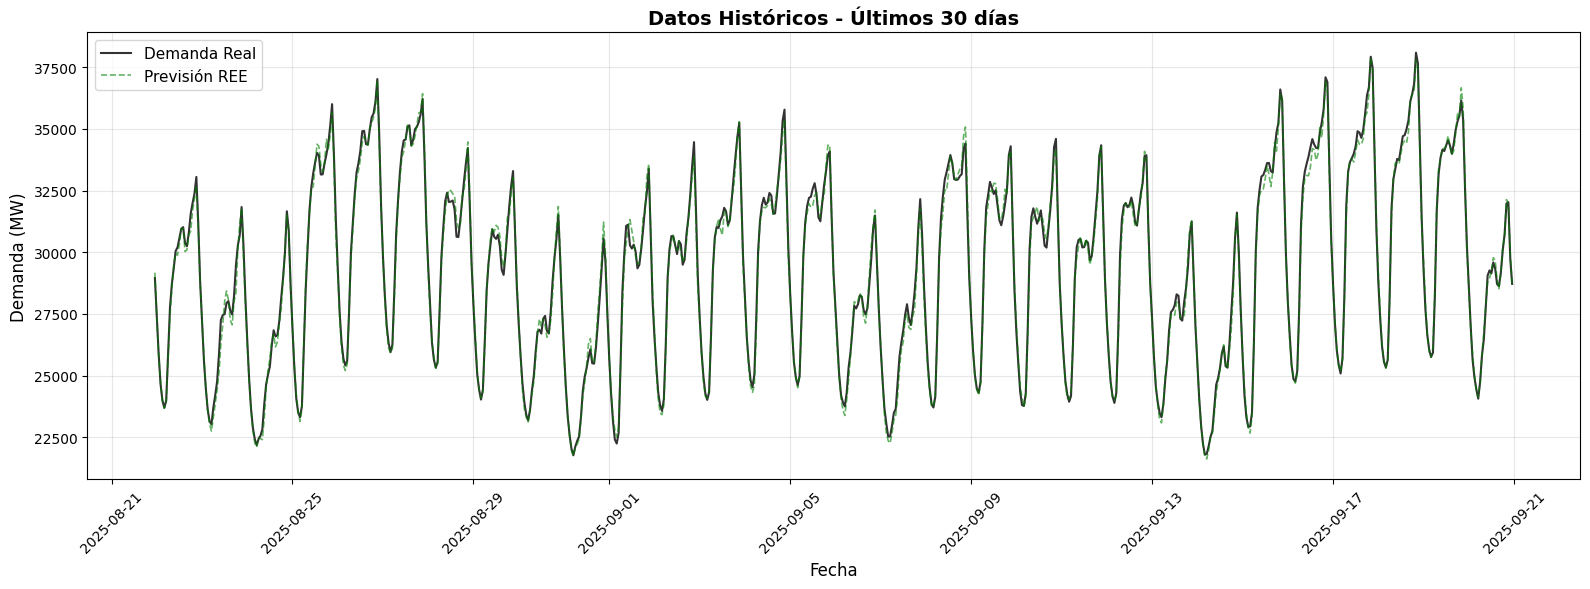


✓ Visualización completada


In [15]:
import matplotlib.pyplot as plt

# Visualizar últimos 30 días
fecha_viz_inicio = df_output['datetime'].max() - pd.Timedelta(days=30)
df_viz = df_output[df_output['datetime'] >= fecha_viz_inicio]

fig, ax = plt.subplots(figsize=(16, 6))

# Demanda real
if not df_viz['demanda_real'].isna().all():
    ax.plot(df_viz['datetime'], df_viz['demanda_real'], 
            label='Demanda Real', color='black', linewidth=1.5, alpha=0.8)

# Previsión REE
if not df_viz['demanda_prevista_ree'].isna().all():
    ax.plot(df_viz['datetime'], df_viz['demanda_prevista_ree'], 
            label='Previsión REE', color='green', linewidth=1.2, alpha=0.6, linestyle='--')

ax.set_title('Datos Históricos - Últimos 30 días', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Demanda (MW)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✓ Visualización completada")